##  Python Analyses Ravens and Deaths
-  Includes the pandas code for organizing datafiles (Ravens + GOT_deaths).
-  Plots of the number of deaths in a season and ravens (messages) sent vs the sentiment score of the lines during the HBO show.

## Data Exploration & Cleanup

-  Using vaderSentiment analyses on JSON script files, we found the compound polarity scores for each episode and wrote into csv files
-  We then used the compiled csv and named it allseasons.csv
-  In order to add the death count per episode we used the downloadable csv found here: https://data.world/aendrew/game-of-thrones-deaths
-  For our analysis, we need the count of ravens per episode and this was done by doing a keyword search in the JSON script files above; keywords used for the purposes of analysis were ('raven','message'). 
-  The most difficult part was to parse through the hits to pick out the relevant data from the irrelevant ones (i.e. three-eyed raven, (raven caws), send them a message)
-  Once all three data files were ready, we could perform the data analysis in python and do data visualization.

## Queries about GoT

-  This analysis will look to see whether there is a link between the sentiment (wording) of the Game of Thrones script and the amount of plot developments (via ravens or messages sent) and also the number of significants deaths.
-  We drill down to the episode level aggregating the sentiment (compound mean) and the count of ravens or deaths that were in each episode.
-  We also want to create a scatter plot of each scenario depicting the comparison and grouping each data plot by season (with the same colors)

##  Conclusion (Write-Up)

-  Exploring the data and comparing the number of ravens(messages) to the sentiment values, we were not able to draw a definitive conclusion. This could be in part due to a lack of keyword hits in the script (not enough data), or it can be attributed to the fact messages were neutral in their composition.

-  In comparing the number of deaths per episode to the sentiment score, it can be concluded that the number of deaths in an episode has minimal effect on the sentiment of the episode script. However when an episode had more than six major character deaths, the sentiment values were all negative.

In [1]:
# Importing dependencies
import pandas as pd
import numpy as np
import codecs
import csv
import matplotlib.pyplot as plt

# File names and read csv
deaths = "Deaths.csv"
ravens = "Ravens.csv"
seasons = "allseasons.csv"

with codecs.open(deaths, "r", encoding='utf-8', errors='ignore') as ddata:
    df_deaths = pd.read_csv(ddata)
    
with codecs.open(ravens, "r", encoding='utf-8', errors='ignore') as rdata:
    df_ravens = pd.read_csv(rdata)
    
with codecs.open(seasons, "r", encoding='utf-8', errors='ignore') as asdata:
    df_seasons = pd.read_csv(asdata)

###  Ravens Analysis

In [2]:
# Clean the df_ravens dataframe
# removing Events: "Delete"

to_drop = ["Delete"]
df_ravens = df_ravens[~df_ravens['Event'].isin(to_drop)]

In [3]:
# Make a DF of the count of ravens sent grouped by GOT episodes

SeasonEp = []
for title in df_ravens["Episode"]:
    epname = title[:6]
    SeasonEp.append(epname)

# Creating a new column removing the title of each epsode
df_ravens["SeasonEp"] = SeasonEp

# Modifying our DF
raven_raw = df_ravens[["SeasonEp","quote_season","quote_episode","Origin","Sender","Destination"]]
raven_raw.columns = ["SeasonEp","Season","Episode","Origin","Sender","Destination"]

# Grouping on Episode (msg count)
ravgrp_ep = raven_raw[["SeasonEp","Season","Episode","Sender"]].groupby(["SeasonEp","Season","Episode"]).agg(['count'])
ravgrp_ep.reset_index(level=["SeasonEp","Season","Episode"],inplace=True)
ravgrp_ep.columns = ravgrp_ep.columns.droplevel(level = 1)

# Merging our polarity scores
rav_comp = ravgrp_ep.merge(df_seasons, on='SeasonEp', how='left')
rav_comp.columns = ["SeasonEp","Season","Episode","Ravens","Polarity"]
rav_comp.head(10)

,SeasonEp,Season,Episode,Ravens,Polarity
0,S01E01,1,1,2,0.028246
1,S01E03,1,3,2,0.007437
2,S01E04,1,4,2,0.052766
3,S01E06,1,6,6,0.004285
4,S01E08,1,8,1,0.013776
5,S01E09,1,9,4,-0.010975
6,S02E01,2,1,3,-0.024909
7,S02E02,2,2,2,0.011428
8,S02E04,2,4,2,0.046129
9,S02E05,2,5,4,0.033784


###  Deaths Analysis

In [4]:
# Making separate two-digit string columns for season and episode
df_deaths['str_season'] = df_deaths['death_season'].astype(str)
df_deaths['str_episode'] = df_deaths['death_episode'].astype(str)
df_deaths['str_season'] = df_deaths['str_season'].apply(lambda x: x.zfill(2))
df_deaths['str_episode'] = df_deaths['str_episode'].apply(lambda x: x.zfill(2))
# New column for SeasonEp which will be a key to join the polarity scores
df_deaths['SeasonEp'] = "S" + df_deaths.str_season.str[:2] + "E" + df_deaths.str_episode.str[:2]
df_deaths = df_deaths[['SeasonEp','death_season','death_episode','name']]
df_deaths.columns = ["SeasonEp","Season","Episode","Name"]

# Cleaning up the DF
deathgrp_ep = df_deaths[["SeasonEp","Season","Episode","Name"]].groupby(["SeasonEp","Season","Episode"]).agg(['count'])
deathgrp_ep.reset_index(level=["SeasonEp","Season","Episode"],inplace=True)
deathgrp_ep.columns = deathgrp_ep.columns.droplevel(level = 1)
# Merging Polarity scores
death_comp = deathgrp_ep.merge(df_seasons, on='SeasonEp', how='left')
death_comp.columns = ["SeasonEp","Season","Episode","Deaths","Polarity"]
death_comp.head(10)


,SeasonEp,Season,Episode,Deaths,Polarity
0,S01E01,1,1,2,0.028246
1,S01E05,1,5,1,-0.013251
2,S01E06,1,6,1,0.004285
3,S01E07,1,7,2,0.001448
4,S01E08,1,8,1,0.013776
5,S01E09,1,9,1,-0.010975
6,S01E10,1,10,3,-0.004266
7,S02E02,2,2,1,0.011428
8,S02E03,2,3,1,0.006471
9,S02E05,2,5,1,0.033784


###  Plot Num Ravens to Polarity (Compound)

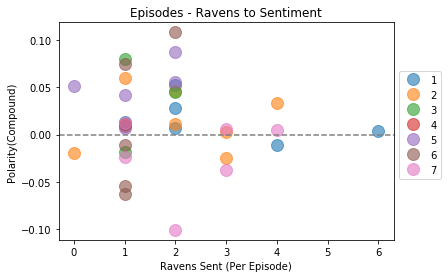

In [5]:
# Make a scatterplot to compare number of ravens per episode to polarity
df_ravplot = pd.DataFrame(dict(x_rav=rav_comp["Ravens"],
                               y_rav=rav_comp["Polarity"],
                               label_rav = rav_comp["Season"]))
ravgroups = df_ravplot.groupby("label_rav")

# ScatterPlot details
fig, ax = plt.subplots()
for episode, group in ravgroups:
    ax.plot(group.x_rav, group.y_rav, marker='o',
            alpha=0.6, linestyle='', ms=12, label=episode)
ax.set_title("Episodes - Ravens to Sentiment")
ax.set_xlabel("Ravens Sent (Per Episode)")
ax.set_ylabel("Polarity(Compound)")
ax.legend(bbox_to_anchor = (1.0,0.8))
ax.axhline(c="grey",ls="--")
plt.savefig("Figures/Ravens.png")
plt.show()

###  Plot Number of Deaths to Polarity (Per Episode)

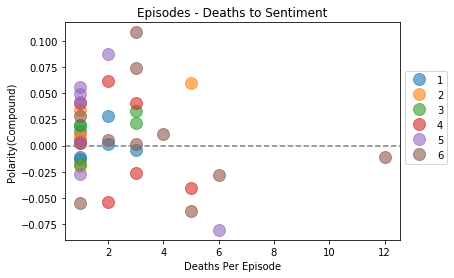

In [6]:
# Make a scatterplot to compare number of deaths per episode to polarity
df_deathplot = pd.DataFrame(dict(x_d=death_comp["Deaths"],
                               y_d=death_comp["Polarity"],
                               label_d = death_comp["Season"].astype(str)))
deadgroups = df_deathplot.groupby("label_d")

# ScatterPlot details
fig, ax = plt.subplots()
for death, group in deadgroups:
    ax.plot(group.x_d, group.y_d, marker='o',
            alpha=0.6, linestyle='', ms=12, label=death)
ax.set_title("Episodes - Deaths to Sentiment")
ax.set_xlabel("Deaths Per Episode")
ax.set_ylabel("Polarity(Compound)")

ax.legend(bbox_to_anchor = (1.0,0.8))
ax.axhline(c="grey",ls="--")
plt.savefig("Figures/Deaths.png")
plt.show()

In [7]:
death_comp.to_csv("DeathPolarity.csv", sep=',', encoding='utf-8')
rav_comp.to_csv("RavenPolarity.csv", sep=',', encoding='utf-8')